### Imports

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import tensorflow
import os 
from PIL import Image
import glob

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import preprocess_input

### Loading the data

In [2]:
train_directory = r"../raw_data/train"

In [3]:
# creating the training dataset as a subset of our 'train' images folder
# labels are inferred from the subfolders

train_dataset = image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=123,
    validation_split=0.2, subset="training", interpolation='bilinear', follow_links=False
)

Found 4317 files belonging to 16 classes.
Using 3454 files for training.


In [4]:
# creating the validation dataset as a subset of our 'train' images folder
# labels are inferred from the subfolders

val_dataset = image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int',
    color_mode='rgb', batch_size=32, image_size=(256, 256), shuffle=True, seed=123,
    validation_split=0.2, subset="validation", interpolation='bilinear', follow_links=False
)

Found 4317 files belonging to 16 classes.
Using 863 files for validation.


In [5]:
img_height, img_width = (256,256)

In [6]:
num_classes = 16

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [7]:
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0

In [9]:
epochs = 1

history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs
)

108/108 [==============================] - 84s 776ms/step - loss: 2.5631 - accuracy: 0.2070 - val_loss: 2.3675 - val_accuracy: 0.2908


### Plotting learning curves

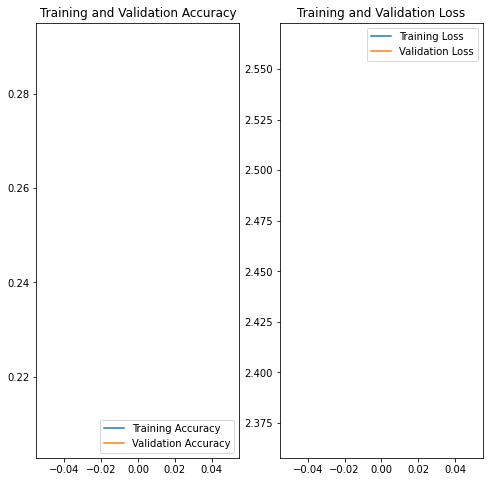

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Making predictions

In [11]:
test_df = pd.read_csv("../plantbase/data/test_data.csv").drop(columns = "Unnamed: 0")

In [12]:
test_df = test_df[['id', 'genus']]
test_df.head()

,id,genus
0,100035,Verbascum
1,100058,Trifolium
2,100186,Veronica
3,100238,Campanula
4,1003,Geranium


In [13]:
test_df.shape

(1341, 2)

In [14]:
test_df[test_df['id'] == 62]

,id,genus
844,62,Trifolium


In [15]:
columns = np.sort(test_df.genus.unique())
columns

array(['Ajuga', 'Allium', 'Campanula', 'Cirsium', 'Crataegus', 'Gentiana',
       'Geranium', 'Iris', 'Malva', 'Narcissus', 'Ophrys', 'Rosa',
       'Trifolium', 'Verbascum', 'Veronica', 'Viola'], dtype=object)

In [16]:
rename_columns = {}
col_index = 0
for n in columns:
    rename_columns[col_index] = n
    col_index += 1
    
rename_columns

{0: 'Ajuga',
 1: 'Allium',
 2: 'Campanula',
 3: 'Cirsium',
 4: 'Crataegus',
 5: 'Gentiana',
 6: 'Geranium',
 7: 'Iris',
 8: 'Malva',
 9: 'Narcissus',
 10: 'Ophrys',
 11: 'Rosa',
 12: 'Trifolium',
 13: 'Verbascum',
 14: 'Veronica',
 15: 'Viola'}

#### loading test images using tensorflow load_img and img_to_array

In [17]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [18]:
%%time

X_list = []
y_list = []

for index, row in test_df.iterrows():
    img = load_img(rf"../raw_data/test/{row.id}.jpg", target_size=(256, 256))
    img = tensorflow.keras.preprocessing.image.img_to_array(img)
    #img = tensorflow.expand_dims(img, 0)
    X_list.append(img)
    y_list.append((row.genus, row.id))

Wall time: 6.82 s


In [19]:
test_df[test_df['id'] == 100238]

,id,genus
3,100238,Campanula


In [20]:
y_true_df = pd.DataFrame(y_list, columns = ['true_genus', 'id'])
y_true_df.head()

,true_genus,id
0,Verbascum,100035
1,Trifolium,100058
2,Veronica,100186
3,Campanula,100238
4,Geranium,1003


In [21]:
X_test = np.stack(X_list, axis=0)

In [22]:
# tst_img = tensorflow.keras.preprocessing.image.load_img(
#     rf"../raw_data/test/62.jpg", target_size=(256, 256))

# tst_img_array = tensorflow.keras.preprocessing.image.img_to_array(tst_img)
# tst_img_array = tensorflow.expand_dims(tst_img_array, 0)

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred.shape

(1341, 16)

In [25]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns = rename_columns)
y_pred_df.head()

,Ajuga,Allium,Campanula,Cirsium,Crataegus,Gentiana,Geranium,Iris,Malva,Narcissus,Ophrys,Rosa,Trifolium,Verbascum,Veronica,Viola
0,-0.375045,-1.099686,-0.711595,0.473100,-1.171707,1.016644,0.122856,0.487261,-0.612631,0.452693,1.685862,-1.336651,-0.011222,1.489159,-2.978709,-1.338057
1,1.976996,-2.604533,0.189381,-2.215130,-2.773472,2.029676,0.528427,2.589401,-0.221971,0.905883,-1.673178,-1.438025,-2.276607,-0.319322,1.084313,1.045270
2,0.150083,-0.651813,0.673039,0.582385,-0.504183,0.727306,1.392239,-0.345021,-0.074036,-1.064208,0.925776,-0.683254,-0.934431,-0.952826,0.104517,-0.144562
3,0.416089,-0.901790,1.403908,0.517593,-0.540563,2.253790,0.440279,0.955896,0.439329,0.088416,0.306997,-1.375822,-1.279450,-1.936976,-0.425926,0.387330
4,0.356223,-0.765871,1.017924,0.210691,-0.437511,0.784489,1.003653,-0.186409,0.282302,-1.088736,0.162990,-0.803298,-1.426403,-1.422720,0.726319,0.201529


In [26]:
y_list

[('Verbascum', 100035),
 ('Trifolium', 100058),
 ('Veronica', 100186),
 ('Campanula', 100238),
 ('Geranium', 1003),
 ('Ophrys', 100304),
 ('Veronica', 10044),
 ('Narcissus', 100448),
 ('Ophrys', 10049),
 ('Campanula', 100670),
 ('Rosa', 100683),
 ('Geranium', 100694),
 ('Viola', 10092),
 ('Allium', 100942),
 ('Trifolium', 100971),
 ('Ophrys', 101000),
 ('Veronica', 101260),
 ('Cirsium', 10130),
 ('Ophrys', 101745),
 ('Campanula', 101829),
 ('Geranium', 101850),
 ('Cirsium', 101884),
 ('Campanula', 101969),
 ('Campanula', 102018),
 ('Crataegus', 10206),
 ('Ophrys', 102082),
 ('Verbascum', 102097),
 ('Geranium', 102239),
 ('Iris', 102252),
 ('Veronica', 102364),
 ('Ophrys', 102365),
 ('Allium', 102550),
 ('Trifolium', 102673),
 ('Verbascum', 102684),
 ('Ajuga', 102850),
 ('Viola', 102881),
 ('Cirsium', 102886),
 ('Viola', 103007),
 ('Ophrys', 103279),
 ('Narcissus', 10335),
 ('Verbascum', 103463),
 ('Ophrys', 103479),
 ('Ophrys', 103568),
 ('Malva', 103570),
 ('Trifolium', 103657),
 ('Tr

In [27]:
y_true = np.stack(y_list, axis = 0)

In [28]:
y_pred_df['pred_genus'] = y_pred_df.idxmax(axis = 1)
y_pred_df['pred_genus']

0          Ophrys
1            Iris
2        Geranium
3        Gentiana
4       Campanula
5          Ophrys
6          Ophrys
7        Gentiana
8          Ophrys
9        Geranium
10       Geranium
11       Geranium
12       Geranium
13       Geranium
14         Ophrys
15         Ophrys
16       Geranium
17       Gentiana
18         Ophrys
19           Iris
20       Geranium
21         Ophrys
22       Gentiana
23         Allium
24          Ajuga
25         Ophrys
26         Ophrys
27         Ophrys
28      Narcissus
29       Gentiana
          ...    
1311     Gentiana
1312       Ophrys
1313     Gentiana
1314     Gentiana
1315       Ophrys
1316     Geranium
1317     Veronica
1318       Ophrys
1319     Geranium
1320     Gentiana
1321     Geranium
1322     Gentiana
1323       Ophrys
1324       Ophrys
1325     Geranium
1326     Gentiana
1327     Geranium
1328       Ophrys
1329     Gentiana
1330     Gentiana
1331         Iris
1332       Ophrys
1333       Ophrys
1334       Ophrys
1335      

In [29]:
prediction_review = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [30]:
prediction_review.count()

1341

In [31]:
prediction_vec_df = y_pred_df[['pred_genus']].copy()
prediction_vec_df['true_genus'] = y_true_df['true_genus'].copy()
prediction_vec_df['result'] = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [32]:
prediction_vec_df['false'] = prediction_vec_df['result'].apply(lambda x: 1 if x == False else 0)
prediction_vec_df['true'] = prediction_vec_df['result'].apply(lambda x: 1 if x == True else 0)
prediction_vec_df.head(2)

,pred_genus,true_genus,result,false,true
0,Ophrys,Verbascum,False,1,0
1,Iris,Trifolium,False,1,0


In [33]:
true_pos_neg = prediction_vec_df.groupby('true_genus').sum().drop(columns=['result'])
true_pos_neg['percent_true'] = true_pos_neg['true'] / (true_pos_neg['true'] + true_pos_neg['false'])

In [34]:
success_ratio = round(true_pos_neg[['percent_true']]*100).sort_values(by='percent_true', ascending=False)

In [35]:
success_ratio

,percent_true
true_genus,
Ophrys,82.0
Gentiana,76.0
Geranium,60.0
Narcissus,47.0
Verbascum,21.0
Campanula,16.0
Iris,6.0
Veronica,2.0
Cirsium,1.0


##### genus success by number of images in dataset

In [52]:
train_df = pd.read_csv('../plantbase/data/priority_plants_VF.csv').drop(columns = 'Unnamed: 0')

In [60]:
success_ratio['sample_size'] = train_df.groupby('genus').count()['content']

In [62]:
success_ratio = success_ratio.drop(columns='Sample Size')
success_ratio

,percent_true,sample_size
true_genus,,
Ophrys,82.0,660
Gentiana,76.0,296
Geranium,60.0,436
Narcissus,47.0,223
Verbascum,21.0,295
Campanula,16.0,381
Iris,6.0,154
Veronica,2.0,200
Cirsium,1.0,231


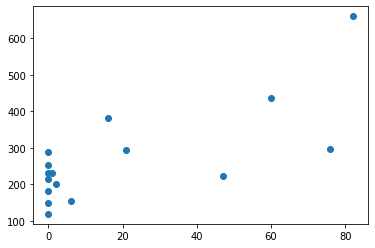

In [63]:
plt.scatter(success_ratio['percent_true'], success_ratio['sample_size'])

<AxesSubplot:xlabel='sample_size', ylabel='percent_true'>

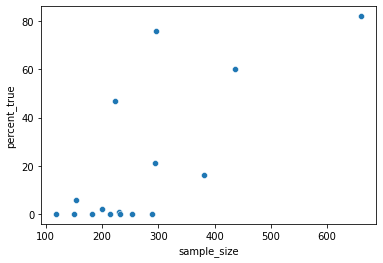

In [64]:
sns.scatterplot(x = success_ratio['sample_size'], y = success_ratio['percent_true'])

#### testing overall accuracy

In [36]:
y_true.shape

(1341, 2)

In [37]:
X_test.shape

(1341, 256, 256, 3)

In [38]:
y_preds = model.predict(X_test)

In [39]:
y_preds.shape

(1341, 16)

In [40]:
y_preds[0]

array([-0.37504542, -1.0996858 , -0.7115953 ,  0.47309953, -1.1717073 ,
        1.0166441 ,  0.12285591,  0.48726088, -0.6126306 ,  0.4526932 ,
        1.6858617 , -1.3366513 , -0.01122154,  1.4891592 , -2.9787095 ,
       -1.3380568 ], dtype=float32)

In [41]:
y_pred_df = pd.DataFrame(y_preds)
y_pred_df = y_pred_df.rename(columns=rename_columns)

y_pred_df.head()

,Ajuga,Allium,Campanula,Cirsium,Crataegus,Gentiana,Geranium,Iris,Malva,Narcissus,Ophrys,Rosa,Trifolium,Verbascum,Veronica,Viola
0,-0.375045,-1.099686,-0.711595,0.473100,-1.171707,1.016644,0.122856,0.487261,-0.612631,0.452693,1.685862,-1.336651,-0.011222,1.489159,-2.978709,-1.338057
1,1.976996,-2.604533,0.189381,-2.215130,-2.773472,2.029676,0.528427,2.589401,-0.221971,0.905883,-1.673178,-1.438025,-2.276607,-0.319322,1.084313,1.045270
2,0.150083,-0.651813,0.673039,0.582385,-0.504183,0.727306,1.392239,-0.345021,-0.074036,-1.064208,0.925776,-0.683254,-0.934431,-0.952826,0.104517,-0.144562
3,0.416089,-0.901790,1.403908,0.517593,-0.540563,2.253790,0.440279,0.955896,0.439329,0.088416,0.306997,-1.375822,-1.279450,-1.936976,-0.425926,0.387330
4,0.356223,-0.765871,1.017924,0.210691,-0.437511,0.784489,1.003653,-0.186409,0.282302,-1.088736,0.162990,-0.803298,-1.426403,-1.422720,0.726319,0.201529


In [42]:
y_true[:,0]

array(['Verbascum', 'Trifolium', 'Veronica', ..., 'Campanula',
       'Campanula', 'Cirsium'], dtype='<U9')

In [43]:
y_pred_df.shape, y_true[:,0].shape

((1341, 16), (1341,))

In [44]:
y_pred_df['pred_genus'] = y_pred_df.idxmax(axis=1)
y_pred_df['true_genus'] = y_true[:,0]

In [45]:
y_pred_df.head()

,Ajuga,Allium,Campanula,Cirsium,Crataegus,Gentiana,Geranium,Iris,Malva,Narcissus,Ophrys,Rosa,Trifolium,Verbascum,Veronica,Viola,pred_genus,true_genus
0,-0.375045,-1.099686,-0.711595,0.473100,-1.171707,1.016644,0.122856,0.487261,-0.612631,0.452693,1.685862,-1.336651,-0.011222,1.489159,-2.978709,-1.338057,Ophrys,Verbascum
1,1.976996,-2.604533,0.189381,-2.215130,-2.773472,2.029676,0.528427,2.589401,-0.221971,0.905883,-1.673178,-1.438025,-2.276607,-0.319322,1.084313,1.045270,Iris,Trifolium
2,0.150083,-0.651813,0.673039,0.582385,-0.504183,0.727306,1.392239,-0.345021,-0.074036,-1.064208,0.925776,-0.683254,-0.934431,-0.952826,0.104517,-0.144562,Geranium,Veronica
3,0.416089,-0.901790,1.403908,0.517593,-0.540563,2.253790,0.440279,0.955896,0.439329,0.088416,0.306997,-1.375822,-1.279450,-1.936976,-0.425926,0.387330,Gentiana,Campanula
4,0.356223,-0.765871,1.017924,0.210691,-0.437511,0.784489,1.003653,-0.186409,0.282302,-1.088736,0.162990,-0.803298,-1.426403,-1.422720,0.726319,0.201529,Campanula,Geranium


In [46]:
prediction_review = (y_pred_df['pred_genus'] == y_pred_df['true_genus'])
accuracy = prediction_review.value_counts()[True] / prediction_review.count()
print(f'test accuracy: {accuracy}')

test accuracy: 0.30275913497390006


In [47]:
y_true

array([['Verbascum', '100035'],
       ['Trifolium', '100058'],
       ['Veronica', '100186'],
       ...,
       ['Campanula', '99914'],
       ['Campanula', '99963'],
       ['Cirsium', '9997']], dtype='<U9')

In [48]:
 # get predictions for all species
y_pred = model.predict(self.X_test)
columns = self.label_enc.classes_
y_pred_df = pd.DataFrame(y_pred, columns=columns)

# get species with top prediction and true species
y_pred_df['pred_genus'] = y_pred_df.idxmax(axis=1)
y_pred_df['true_genus'] = self.y_test

# measure success rate
prediction_review = (y_pred_df['pred_genus'] == y_pred_df['true_genus'])
accuracy = prediction_review.value_counts()[True] / prediction_review.count()
print(f'test accuracy: {accuracy}')

IndentationError: unexpected indent (<ipython-input-48-ec697ced28db>, line 2)